## Thiago Caveglion - Decision Tree
---

### Tratamento inicial do dataset

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from scipy.stats import uniform
import joblib
from sklearn.tree import DecisionTreeClassifier


In [7]:
pd.set_option('display.max_columns', None)

In [8]:
local = True
caminho = "./datasets/" if local else "/content/drive/MyDrive/Projeto ML1 - Fraude/"


df_train = pd.read_csv(caminho + "fraudTrain.csv", parse_dates=['trans_date_trans_time',])
df_test = pd.read_csv(caminho + "/fraudTest.csv", parse_dates=['trans_date_trans_time',])


Verificação de nulos (o dataset não apresentou valores nulos)

In [9]:
df_train['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [10]:
df_test['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

In [11]:
df_test.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [12]:
df_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

### Análise exploratória dos dados

Antes mesmo de construir features e tratar as colunas, será feita uma EDA para concluir quais features podem contribuir com o modelo.

In [13]:
df_analise = df_train.copy()

In [14]:
df_fraudado = df_analise[df_analise["is_fraud"] == 1]
df_fraudado.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,TX,78208,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,TX,78208,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,NC,28611,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,TX,78208,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1


In [15]:
quantidade_fraudes = len(df_fraudado)

In [16]:
quantidade_cartoes = len(df_fraudado["cc_num"].unique())

In [17]:
media = quantidade_fraudes/quantidade_cartoes
print(f"a média é {media:.2f}")

a média é 9.85


Cerca de 10 fraudes são cometidas por cada cartão que comete uma fraude, portanto pode ser interessante visualizar as fraudes por número de cartão.

In [18]:
df_fraudado["gender"].value_counts(normalize=True)

gender
M    0.502398
F    0.497602
Name: proportion, dtype: float64

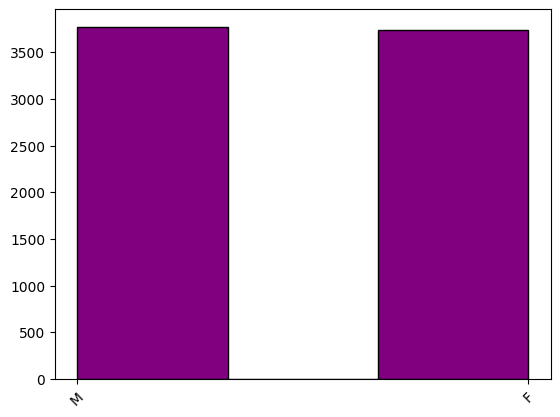

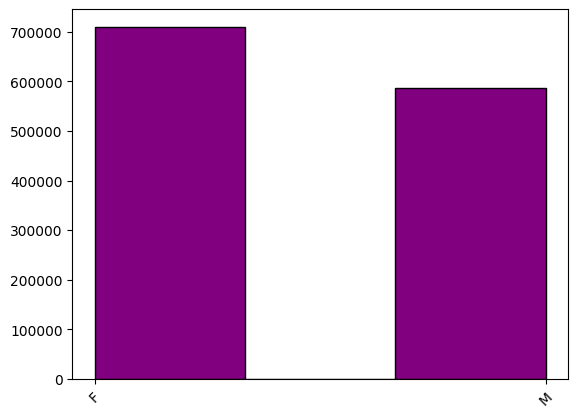

In [19]:
plt.hist(df_fraudado["gender"], color="purple", edgecolor="black", bins=3)
plt.xticks(rotation=45)
plt.show()
plt.hist(df_analise["gender"], color="purple", edgecolor="black", bins=3)
plt.xticks(rotation=45)
plt.show()

Verifica-se que a proporção entre gêneros que cometem fraude é muito parecida, o que torna esse fator provavelmente não predominante. Porém, observa-se que no dataset geral existe uma quantia relevantemente maior de mulheres, o que pode indicar que, proporcionalmente, os homens cometem mais fraudes.

In [20]:
df_fraudado["amt"].mean()

531.3200919264589

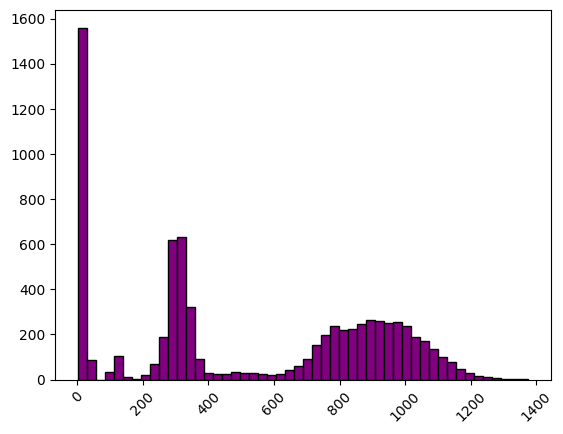

In [21]:
plt.hist(df_fraudado["amt"], color="purple", edgecolor="black", bins=50)
plt.xticks(rotation=45)
plt.show()

A média das compras fraudadas é 531 dólares, o que indica que, provavelmente, um valor mais alto de compra está relacionado com a possibilidade da compra ser fraudada. Além disso, a grande quantidade observada no começo do gráfico pode indicar diversas fraudes menores como uma tentativa de não levantar suspeitas sobre a fraude.

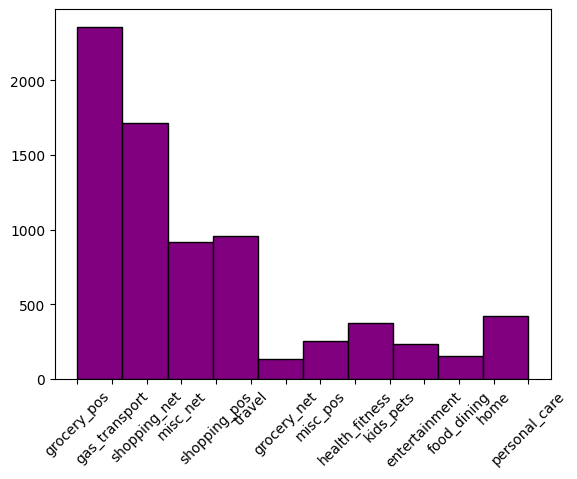

In [22]:
plt.hist(df_fraudado["category"], color="purple", edgecolor="black")
plt.xticks(rotation=45)
plt.show()

A porcentagem de compras fraudadas está muito concentrada nas categorias: grocery_pos, shopping_net, misc_net e shopping_pos, o que indica que essa variável categórica pode ter uma grande importância para o modelo.

In [23]:
df_fraudado["state"].value_counts(normalize=True)

state
NY    0.073941
TX    0.063816
PA    0.061018
CA    0.043432
OH    0.042766
FL    0.037437
IL    0.033040
MI    0.031708
AL    0.028644
MN    0.027578
VA    0.026379
SC    0.025713
MO    0.025446
NE    0.023981
WI    0.021716
AR    0.021450
MD    0.020917
KS    0.020783
KY    0.020650
OR    0.019851
NC    0.019851
GA    0.019451
WV    0.019451
OK    0.019051
IA    0.018918
IN    0.018918
TN    0.018652
ME    0.015854
NJ    0.015721
MS    0.015321
CO    0.015055
WY    0.014655
WA    0.012790
LA    0.012124
NM    0.010925
SD    0.009859
VT    0.009592
MA    0.009193
UT    0.008127
NH    0.007860
ND    0.007594
NV    0.006262
AZ    0.004929
AK    0.004796
MT    0.004263
DC    0.002798
CT    0.002132
RI    0.001998
ID    0.001465
DE    0.001199
HI    0.000933
Name: proportion, dtype: float64

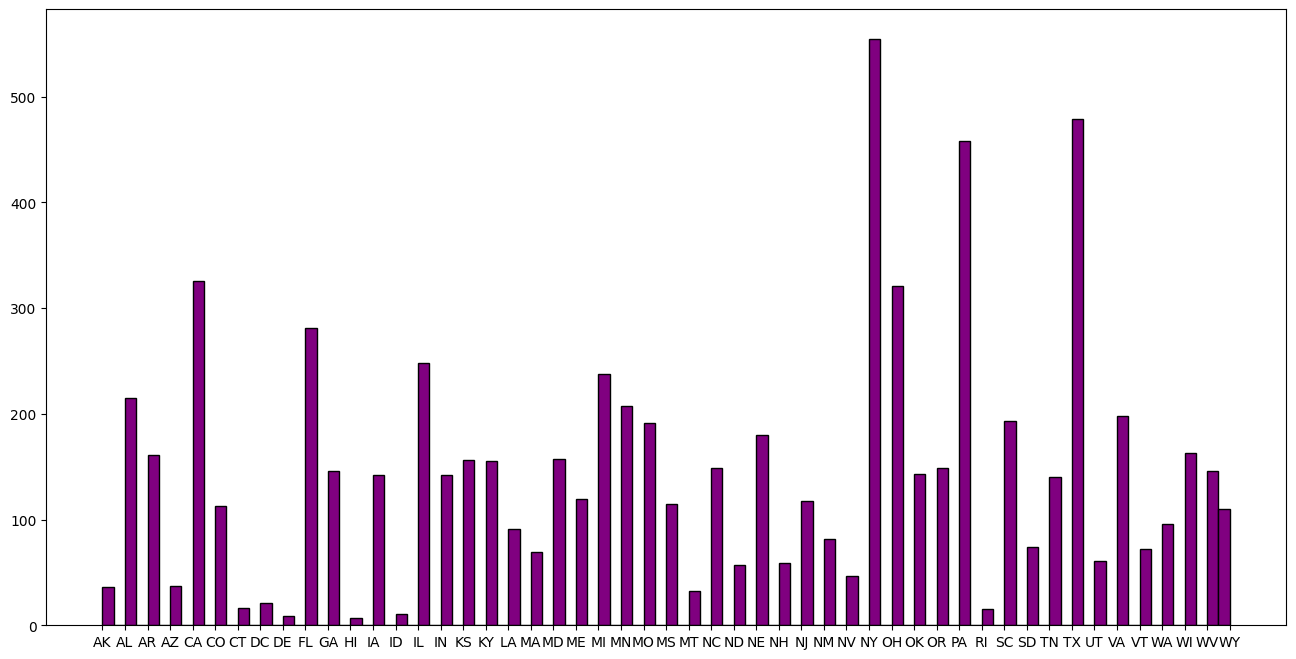

In [24]:
plt.figure(figsize=(16, 8))
plt.hist(sorted(df_fraudado["state"]), color="purple", edgecolor="black", bins=100)
plt.show()

O número de fraudes por cidade parece estar diretamente relacionado com a população da mesma, então essa métrica é muito abstrata e não relevante para o escopo do modelo

Além dessas features ponderadas, concluímos que algumas colunas categóricas não são tão relevantes para o modelo. Além disso, intuitivamente construiremos novas features: Idade do comprador, distância do comprador da loja, hora da transação (classificada como normal ou anormal), frequência de transações nos últimos dias e diferença de tempo entre a transação atual e a última transação.

### Tratamento das colunas categóricas e construção de features

Nesse momento, criaremos as features imaginadas na análise exploratória

In [25]:
df_thiago_treino = df_train.copy()
df_thiago_teste = df_test.copy()

In [26]:
df_thiago_treino.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0


In [27]:
df_thiago_teste.head(1)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0


Construindo uma feature que adiciona a hora da transação e a classifica como normal (0) ou anormal (1)

In [28]:
df_thiago_treino['hour'] = df_thiago_treino.trans_date_trans_time.dt.hour
df_thiago_treino['hourEnc'] = 0
df_thiago_treino.loc[df_thiago_treino.hour < 5,'hourEnc'] = 1
df_thiago_treino.loc[df_thiago_treino.hour > 21,'hourEnc'] = 1


df_thiago_teste['hour'] = df_thiago_teste.trans_date_trans_time.dt.hour
df_thiago_teste['hourEnc'] = 0
df_thiago_teste.loc[df_thiago_teste.hour < 5,'hourEnc'] = 1
df_thiago_teste.loc[df_thiago_teste.hour > 21,'hourEnc'] = 1



Construindo uma feature que adiciona frequência de transações

In [29]:
def last_1_day_transaction_count(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_1_day').sort_index()
    count_1_day = temp.rolling('1d').count() - 1
    count_1_day.index = temp.values
    x['count_1_day'] = count_1_day.reindex(x.index)
    return x


def last_7_days_transaction_count(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_7_days').sort_index()
    count_7_days = temp.rolling('7d').count() - 1
    count_7_days.index = temp.values
    x['count_7_days'] = count_7_days.reindex(x.index)
    return x


def last_30_days_transaction_count(x):
    temp = pd.Series(x.index, index = x.trans_date_trans_time, name='count_30_days').sort_index()
    count_30_days = temp.rolling('30d').count() - 1
    count_30_days.index = temp.values
    x['count_30_days'] = count_30_days.reindex(x.index)
    return x

In [30]:
df_teste_features = df_thiago_teste.groupby("cc_num").apply(last_1_day_transaction_count)
df_treino_features = df_thiago_treino.groupby("cc_num").apply(last_1_day_transaction_count)

In [31]:
df_teste_features = df_thiago_teste.groupby("cc_num").apply(last_7_days_transaction_count)
df_treino_features = df_thiago_treino.groupby("cc_num").apply(last_7_days_transaction_count)


In [32]:
df_teste_features = df_thiago_teste.groupby("cc_num").apply(last_30_days_transaction_count)
df_treino_features = df_thiago_treino.groupby("cc_num").apply(last_30_days_transaction_count)

In [33]:
df_teste_features.drop(columns="cc_num", inplace=True)
df_treino_features.drop(columns="cc_num", inplace=True)

In [34]:
df_treino_features

Unnamed: 0 trans_date_trans_time  \
cc_num                                                          
60416207185         1017           1017   2019-01-01 12:47:15   
                    2724           2724   2019-01-02 08:44:57   
                    2726           2726   2019-01-02 08:47:36   
                    2882           2882   2019-01-02 12:38:14   
                    2907           2907   2019-01-02 13:10:46   
...                                 ...                   ...   
4992346398065154184 1294934     1294934   2020-06-20 21:04:59   
                    1295369     1295369   2020-06-21 00:41:01   
                    1295587     1295587   2020-06-21 02:47:59   
                    1296206     1296206   2020-06-21 08:04:28   
                    1296427     1296427   2020-06-21 09:58:58   

                                                      merchant       category  \
cc_num                                                                          
60416207185         1017     fraud_Jones, Sawayn and Romaguera       misc_net   
                    2724                       fraud_Berge LLC  gas_transport   
                    2726                    fraud_Luettgen PLC  gas_transport   
                    2882                   fraud_Daugherty LLC      kids_pets   
                    2907                  fraud_Beier and Sons           home   
...                                                        ...            ...   
4992346398065154184 1294934    fraud_Berge, Kautzer and Harris  personal_care   
                    1295369                 fraud_Bernhard Inc  gas_transport   
                    1295587      fraud_Reichert, Rowe and Mraz   shopping_net   
                    1296206                   fraud_Jewess LLC   shopping_pos   
                    1296427      fraud_Reilly, Heaney and Cole  gas_transport   

                                amt     first  last gender             street  \
cc_num                                                                          
60416207185         1017       7.27      Mary  Diaz      F   9886 Anita Drive   
                    2724      52.94      Mary  Diaz      F   9886 Anita Drive   
                    2726      82.08      Mary  Diaz      F   9886 Anita Drive   
                    2882      34.79      Mary  Diaz      F   9886 Anita Drive   
                    2907      27.18      Mary  Diaz      F   9886 Anita Drive   
...                             ...       ...   ...    ...                ...   
4992346398065154184 1294934   60.47  Benjamin   Kim      M  920 Patrick Light   
                    1295369   74.29  Benjamin   Kim      M  920 Patrick Light   
                    1295587  246.56  Benjamin   Kim      M  920 Patrick Light   
                    1296206    2.62  Benjamin   Kim      M  920 Patrick Light   
                    1296427   39.29  Benjamin   Kim      M  920 Patrick Light   

                                      city state    zip      lat      long  \
cc_num                                                                       
60416207185         1017     Fort Washakie    WY  82514  43.0048 -108.8964   
                    2724     Fort Washakie    WY  82514  43.0048 -108.8964   
                    2726     Fort Washakie    WY  82514  43.0048 -108.8964   
                    2882     Fort Washakie    WY  82514  43.0048 -108.8964   
                    2907     Fort Washakie    WY  82514  43.0048 -108.8964   
...                                    ...   ...    ...      ...       ...   
4992346398065154184 1294934        Mc Nabb    IL  61335  41.1730  -89.2187   
                    1295369        Mc Nabb    IL  61335  41.1730  -89.2187   
                    1295587        Mc Nabb    IL  61335  41.1730  -89.2187   
                    1296206        Mc Nabb    IL  61335  41.1730  -89.2187   
                    1296427        Mc Nabb    IL  61335  41.1730  -89.2187   

                             city_pop                       

Construindo uma feature de diferença de tempo desde a última transação

In [35]:
def timeDifference(x):
    x['time_diff'] = x.trans_date_trans_time - x.trans_date_trans_time.shift()
    return x

In [36]:
df_teste_features = df_teste_features.groupby('cc_num', as_index=None).apply(timeDifference)
df_treino_features = df_treino_features.groupby('cc_num', as_index=None).apply(timeDifference)

In [37]:
df_teste_features['time_diff'] = df_teste_features['time_diff'].dt.seconds
df_treino_features['time_diff'] = df_treino_features['time_diff'].dt.seconds

In [38]:
df_treino_features

Unnamed: 0 trans_date_trans_time  \
    cc_num                                                          
0   60416207185         1017           1017   2019-01-01 12:47:15   
                        2724           2724   2019-01-02 08:44:57   
                        2726           2726   2019-01-02 08:47:36   
                        2882           2882   2019-01-02 12:38:14   
                        2907           2907   2019-01-02 13:10:46   
...                                     ...                   ...   
982 4992346398065154184 1294934     1294934   2020-06-20 21:04:59   
                        1295369     1295369   2020-06-21 00:41:01   
                        1295587     1295587   2020-06-21 02:47:59   
                        1296206     1296206   2020-06-21 08:04:28   
                        1296427     1296427   2020-06-21 09:58:58   

                                                          merchant  \
    cc_num                                                           
0   60416207185         1017     fraud_Jones, Sawayn and Romaguera   
                        2724                       fraud_Berge LLC   
                        2726                    fraud_Luettgen PLC   
                        2882                   fraud_Daugherty LLC   
                        2907                  fraud_Beier and Sons   
...                                                            ...   
982 4992346398065154184 1294934    fraud_Berge, Kautzer and Harris   
                        1295369                 fraud_Bernhard Inc   
                        1295587      fraud_Reichert, Rowe and Mraz   
                        1296206                   fraud_Jewess LLC   
                        1296427      fraud_Reilly, Heaney and Cole   

                                      category     amt     first  last gender  \
    cc_num                                                                      
0   60416207185         1017          misc_net    7.27      Mary  Diaz      F   
                        2724     gas_transport   52.94      Mary  Diaz      F   
                        2726     gas_transport   82.08      Mary  Diaz      F   
                        2882         kids_pets   34.79      Mary  Diaz      F   
                        2907              home   27.18      Mary  Diaz      F   
...                                        ...     ...       ...   ...    ...   
982 4992346398065154184 1294934  personal_care   60.47  Benjamin   Kim      M   
                        1295369  gas_transport   74.29  Benjamin   Kim      M   
                        1295587   shopping_net  246.56  Benjamin   Kim      M   
                        1296206   shopping_pos    2.62  Benjamin   Kim      M   
                        1296427  gas_transport   39.29  Benjamin   Kim      M   

                                            street           city state  \
    cc_num                                                                
0   60416207185         1017      9886 Anita Drive  Fort Washakie    WY   
                        2724      9886 Anita Drive  Fort Washakie    WY   
                        2726      9886 Anita Drive  Fort Washakie    WY   
                        2882      9886 Anita Drive  Fort Washakie    WY   
                        2907      9886 Anita Drive  Fort Washakie    WY   
...                                            ...            ...   ...   
982 4992346398065154184 1294934  920 Patrick Light        Mc Nabb    IL   
                        1295369  920 Patrick Light        Mc Nabb    IL   
                        1295587  920 Patrick Light        Mc Nabb    IL   
                        1296206  920 Patrick Light        Mc Nabb    IL   
                        1296427  920 Patrick Light        Mc Nabb    IL   

                                   zip      lat      long  city_pop  \
    cc_num                                                            
0   60416207185         1017     82514  43.0048 -108

Exclusão de colunas não relevantes para o modelo

In [39]:
excluir_colunas = ['Unnamed: 0','merchant','trans_num','unix_time','first','last','street','zip','city']

In [40]:
def drop_columns(dataset, iterable):
    dataset.drop(columns=iterable, inplace=True)

drop_columns(df_teste_features, excluir_colunas)
drop_columns(df_treino_features, excluir_colunas)

In [41]:
df_treino_features

trans_date_trans_time       category     amt  \
    cc_num                                                                     
0   60416207185         1017      2019-01-01 12:47:15       misc_net    7.27   
                        2724      2019-01-02 08:44:57  gas_transport   52.94   
                        2726      2019-01-02 08:47:36  gas_transport   82.08   
                        2882      2019-01-02 12:38:14      kids_pets   34.79   
                        2907      2019-01-02 13:10:46           home   27.18   
...                                               ...            ...     ...   
982 4992346398065154184 1294934   2020-06-20 21:04:59  personal_care   60.47   
                        1295369   2020-06-21 00:41:01  gas_transport   74.29   
                        1295587   2020-06-21 02:47:59   shopping_net  246.56   
                        1296206   2020-06-21 08:04:28   shopping_pos    2.62   
                        1296427   2020-06-21 09:58:58  gas_transport   39.29   

                                gender state      lat      long  city_pop  \
    cc_num                                                                  
0   60416207185         1017         F    WY  43.0048 -108.8964      1645   
                        2724         F    WY  43.0048 -108.8964      1645   
                        2726         F    WY  43.0048 -108.8964      1645   
                        2882         F    WY  43.0048 -108.8964      1645   
                        2907         F    WY  43.0048 -108.8964      1645   
...                                ...   ...      ...       ...       ...   
982 4992346398065154184 1294934      M    IL  41.1730  -89.2187       532   
                        1295369      M    IL  41.1730  -89.2187       532   
                        1295587      M    IL  41.1730  -89.2187       532   
                        1296206      M    IL  41.1730  -89.2187       532   
                        1296427      M    IL  41.1730  -89.2187       532   

                                                         job         dob  \
    cc_num                                                                 
0   60416207185         1017     Information systems manager  1986-02-17   
                        2724     Information systems manager  1986-02-17   
                        2726     Information systems manager  1986-02-17   
                        2882     Information systems manager  1986-02-17   
                        2907     Information systems manager  1986-02-17   
...                                                      ...         ...   
982 4992346398065154184 1294934       Audiological scientist  1956-01-09   
                        1295369       Audiological scientist  1956-01-09   
                        1295587       Audiological scientist  1956-01-09   
                        1296206       Audiological scientist  1956-01-09   
                        1296427       Audiological scientist  1956-01-09   

                                 merch_lat  merch_long  is_fraud  hour  \
    cc_num                                                               
0   60416207185         1017     43.974711 -109.741904         0    12   
                        2724     42.018766 -109.044172         0     8   
                        2726     42.961335 -109.157564         0     8   
                        2882     42.228227 -108.747683         0    12   
                        2907     43.321745 -108.091143         0    13   
...                                    ...         ...       ...   ...   
982 4992346398065154184 1294934  40.475395  -89.076105         0    21   
                        1295369  40.743634  -89.553379         0     0   
                        1295587  40.215418  -88.682562         0     2   
                        1296206  40.762861  -88.744967         0     8   
                        1296427  40.699593  -89.230938         0     9   

                                 hour

Convertendo as datas para fazer cálculos com elas

In [42]:
def convert_date(dataset):
    dataset['trans_date_trans_time']=pd.to_datetime(dataset['trans_date_trans_time'])
    dataset['trans_date']=dataset['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
    dataset['trans_date']=pd.to_datetime(dataset['trans_date'])
    dataset['dob']=pd.to_datetime(dataset['dob'])



convert_date(df_treino_features)
convert_date(df_teste_features)


Construindo uma feature baseada em converter as datas em idades das pessoas

In [43]:
def calculate_age(dataset):
    dataset["age"] = dataset["trans_date"] - dataset["dob"]
    dataset["age"] = dataset["age"].dt.days//365

calculate_age(df_treino_features)
calculate_age(df_teste_features)



Construindo uma feature de distância entre o comerciante e o local de residência

In [44]:
def calculate_distance(dataset):
    dataset['latitudinal_distance'] = abs(round(dataset['merch_lat']-dataset['lat'],3))
    dataset['longitudinal_distance'] = abs(round(dataset['merch_long']-dataset['long'],3))

calculate_distance(df_treino_features)
calculate_distance(df_teste_features)


Dropando colunas categóricas desnecessárias para o modelo

In [45]:
dropar_columns = ['trans_date_trans_time','lat','long','job','dob','merch_lat','merch_long','trans_date','state']
drop_columns(df_treino_features, dropar_columns)
drop_columns(df_teste_features, dropar_columns)


Convertendo a feature categórica "gênero" de M para 1 e de F para 0

In [46]:
def convert_gender(dataset):
    dataset.gender = dataset.gender.apply(lambda x: 1 if x == "M" else 0)

convert_gender(df_treino_features)
convert_gender(df_teste_features)

Utilizando o get_dummies do pandas para gerar variaveis booleanas para as categóricas

In [47]:
def dummies(dataset):
    return pd.get_dummies(dataset, columns=["category"], prefix="category")

df_treino_features = dummies(df_treino_features)
df_teste_features = dummies(df_teste_features)

Verificando as colunas do dataframe

In [48]:
df_treino_features.head(1)

,,,amt,gender,city_pop,is_fraud,hour,hourEnc,count_30_days,time_diff,age,latitudinal_distance,longitudinal_distance,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
,cc_num,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60416207185,1017,7.27,0,1645,0,12,0,0.0,NaN,32,0.97,0.846,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [49]:
df_teste_features.head(1)

,,,amt,gender,city_pop,is_fraud,hour,hourEnc,count_30_days,time_diff,age,latitudinal_distance,longitudinal_distance,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
,cc_num,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60416207185,157,124.66,0,1645,0,13,0,0.0,NaN,34,0.059,0.365,False,False,False,False,False,False,True,False,False,False,False,False,False,False


### Salvando o dataset em uma variável no disco rígido com joblib


Essa biblioteca será muito utilizada para salvar os modelos

In [50]:
# joblib.dump(df_treino_features, "dataframes/df_treino_features", compress=7)
# joblib.dump(df_teste_features, "dataframes/df_teste_features", compress=7)

### Testando se o dataframe descompactado é igual ao dataframe original

Teste da descompactação do modelo


In [51]:
df_teste_compressao = joblib.load("dataframes/df_treino_features")
all(df_teste_compressao == df_treino_features)

True

### Carregando o dataset do disco rígido

Carregando o dataset utilizando a biblioteca joblib

In [52]:
df_thiago_treino = joblib.load("dataframes/df_treino_features")
df_thiago_teste = joblib.load("dataframes/df_teste_features")

In [53]:
df_thiago_treino.describe()

,amt,gender,city_pop,is_fraud,hour,hourEnc,count_30_days,time_diff,age,latitudinal_distance,longitudinal_distance
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.295692e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,7.035104e+01,4.525513e-01,8.882444e+04,5.788652e-03,1.280486e+01,2.674109e-01,1.030437e+02,2.243763e+04,4.552822e+01,5.002626e-01,5.003366e-01
std,1.603160e+02,4.977437e-01,3.019564e+05,7.586269e-02,6.817824e+00,4.426087e-01,5.261160e+01,2.123427e+04,1.740895e+01,2.885700e-01,2.888704e-01
min,1.000000e+00,0.000000e+00,2.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,0.000000e+00,0.000000e+00
25%,9.650000e+00,0.000000e+00,7.430000e+02,0.000000e+00,7.000000e+00,0.000000e+00,6.500000e+01,5.671000e+03,3.200000e+01,2.500000e-01,2.500000e-01
50%,4.752000e+01,0.000000e+00,2.456000e+03,0.000000e+00,1.400000e+01,0.000000e+00,9.800000e+01,1.507300e+04,4.400000e+01,5.010000e-01,5.000000e-01
75%,8.314000e+01,1.000000e+00,2.032800e+04,0.000000e+00,1.900000e+01,1.000000e+00,1.350000e+02,3.351000e+04,5.700000e+01,7.500000e-01,7.510000e-01
max,2.894890e+04,1.000000e+00,2.906700e+06,1.000000e+00,2.300000e+01,1.000000e+00,3.610000e+02,8.639900e+04,9.500000e+01,1.000000e+00,1.000000e+00


### Divisão das variáveis em treino e teste

O dataset já estava dividido em treino/teste, então nao foi necessário utilizar o método do sklearn

In [54]:
X_train = df_thiago_treino.drop(columns=["is_fraud"], axis=1)
y_train = df_thiago_treino["is_fraud"]
X_test = df_thiago_teste.drop(columns=["is_fraud"], axis=1)
y_test = df_thiago_teste["is_fraud"]

In [55]:
y_train.value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [56]:
y_test.value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

Visualização do heatmap das correlações de spearman com as variáveis do dataframe

<Axes: >

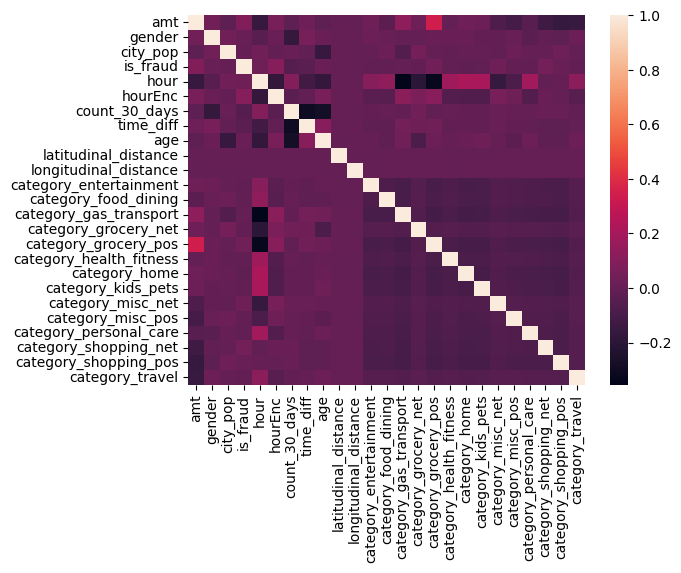

In [57]:
sns.heatmap(df_thiago_treino.corr(method="spearman", numeric_only=True))

### Treinamento do primeiro modelo

Primeiro modelo treinado, sem tratamento especial

In [58]:
modelo_arvore_decisao = DecisionTreeClassifier()
modelo_arvore_decisao.fit(X_train, y_train)

DecisionTreeClassifier()

Persistência em disco do modelo utilizando o joblib

In [59]:
# joblib.dump(modelo_arvore_decisao, filename="./modelos/modelo_1")

### Observando a acurácia do modelo com matrizes de confusão

Acurácia observada com as matrizes de confusão. As cores não são bem representativas e esse problema será resolvido posteriormente

<Figure size 640x480 with 0 Axes>

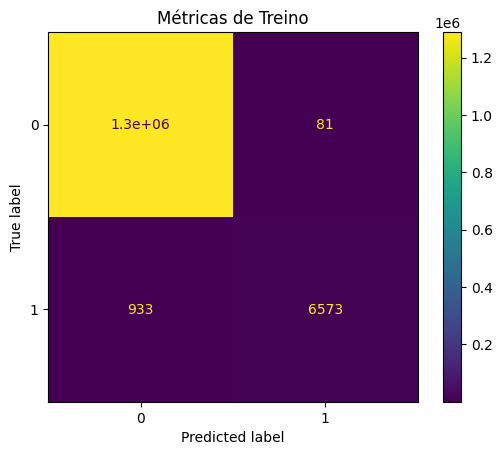

In [60]:
plt.figure()
y_pred_train = modelo_arvore_decisao.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.title("Métricas de Treino")
plt.show()

<Figure size 640x480 with 0 Axes>

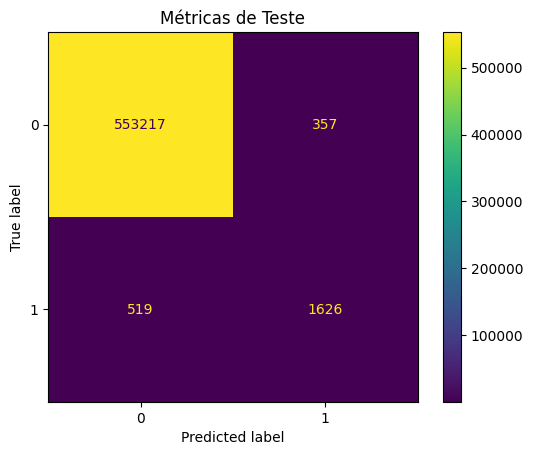

In [61]:
plt.figure()
y_pred_test = modelo_arvore_decisao.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.title("Métricas de Teste")
plt.show()

In [62]:
acuracia_decision_tree = round(accuracy_score(y_test,y_pred_test)*100,2)
acuracia_decision_tree

99.84

A precisão parece muito alta, porém deve-se analisar os falsos negativos e positivos em relação aos verdadeiros positivos: como a escala de fraudes é muito pequena (cerca de 0,5% do dataframe) o modelo provavelmente está errando nesse contexto

In [63]:
matriz_de_confusao_baseline = confusion_matrix(y_test, y_pred_test)
matriz_de_confusao_baseline


array([[553217,    357],
       [   519,   1626]], dtype=int64)

### Definindo uma função de recall

Definindo uma função de recall para analisar os falsos positivos/negativos

In [64]:
def recall(test_y, test_pred_y, fraud): # utiliza 0 para os não fraudados e 1 para os fraudados
    matriz = confusion_matrix(test_y, test_pred_y)
    return matriz[fraud][fraud]/sum(matriz[fraud])

### Definindo uma função de precision

Definindo uma função de precisão para analisar a acurácia do modelo

In [65]:
def precision(test_y, test_pred_y, fraud): # utiliza 0 para os não fraudados e 1 para os fraudados
    matriz = confusion_matrix(test_y, test_pred_y)
    return matriz[fraud][fraud]/(matriz[abs(fraud-1)][fraud] + matriz[fraud][fraud])

### Testando as funções

Numericamente, o recall somente em relação às fraudes foi de:

In [66]:
recall(y_test, y_pred_test, 1)

0.7580419580419581

E o recall em relação às não fraudulentas foi de:

In [67]:
recall(y_test, y_pred_test, 0)

0.9993550997698591

O motivo do accuracy score geral ser muito alto se dá pelo modelo ter grande parte da base de dados como transações não fraudadas, então a precisão do modelo nesse escopo é muito mais alta que no resto.

### Fazendo uma matriz de confusão percentual com base no teste de recall e precisão individual

A matriz de confusão anterior é muito confusa (ironicamente). Não é possível interpretar de maneira correta as cores dela, visto que suas variáveis estão muito distantes em proporção. Por conta disso, será feita uma função que deixa os valores na mesma escala (percentual)

Criação de uma matriz percentual para observação utilizando heatmap

In [68]:
def matriz_percentual_recall(test_y, test_pred_y, title=None):
    rcc_fraud, rcc_non_fraud = recall(test_y, test_pred_y, 0), recall(test_y, test_pred_y, 1)
    complement_fraud, complement_non_fraud = 1 - rcc_fraud, 1- rcc_non_fraud
    matriz = [[rcc_fraud, complement_fraud], [complement_non_fraud, rcc_non_fraud]]
    sns.heatmap(matriz, annot=True, fmt="f")
    if title: plt.title(title)


In [69]:
def matriz_percentual_precision(test_y, test_pred_y, title=None):
    acc_fraud, acc_non_fraud = precision(test_y, test_pred_y, 0), precision(test_y, test_pred_y, 1)
    complement_fraud, complement_non_fraud = 1 - acc_fraud, 1- acc_non_fraud
    matriz = [[acc_fraud, complement_fraud], [complement_non_fraud, acc_non_fraud]]
    sns.heatmap(matriz, annot=True, fmt="f")
    if title: plt.title(title)

Aplicando as matrizes para o modelo

In [70]:
resultados = [y_test, y_pred_test]

Sem nenhuma otimização, o modelo já tem um ótimo f1-score, porém queremos aumentar a precisão

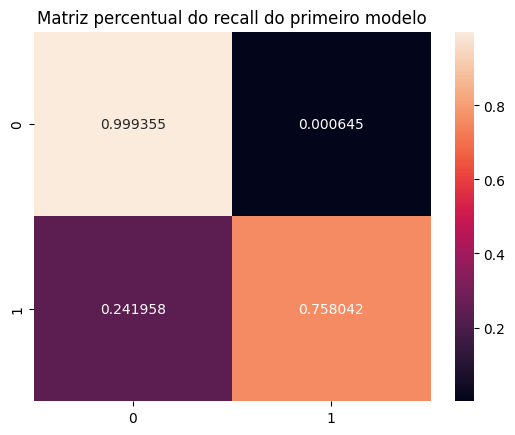

In [71]:
matriz_percentual_recall(*resultados, title="Matriz percentual do recall do primeiro modelo")

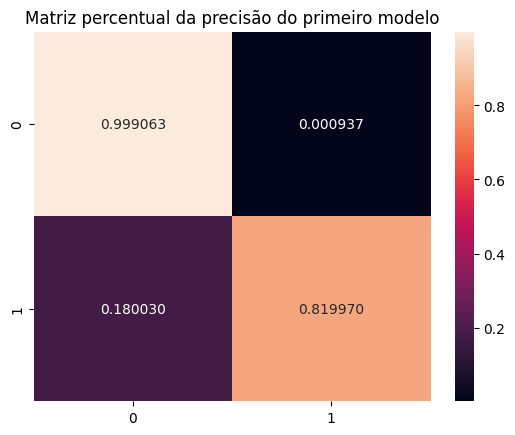

In [72]:
matriz_percentual_precision(*resultados, title= "Matriz percentual da precisão do primeiro modelo")

Dessa forma é bem mais viável observar a precisão do modelo com as cores da matriz

In [73]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.82      0.76      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.88      0.89    555719
weighted avg       1.00      1.00      1.00    555719



### Otimização de hiper-parâmetros

Utilização de pesos para otimizar a classe minoritária (fraudulenta)

In [74]:
modelo_arvore_decisao_weight = DecisionTreeClassifier(class_weight={0: 1, 1: 400, 2: 1})
modelo_arvore_decisao_weight.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 1, 1: 400, 2: 1})

Persistindo em disco o modelo 2

In [75]:
# joblib.dump(modelo_arvore_decisao_weight, filename="./modelos/modelo_2")

Previsão do modelo

In [76]:
y_pred_test_weight = modelo_arvore_decisao_weight.predict(X_test)

Aplicação da matriz


In [77]:
resultados = [y_test, y_pred_test_weight]

O teste com o peso da variável tem uma péssima precisão, o que será consertado com a otimização utilizando grid search

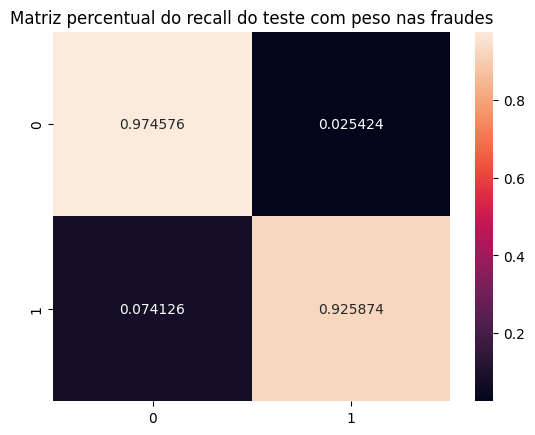

In [78]:
titulo = "Matriz percentual do recall do teste com peso nas fraudes"
matriz_percentual_recall(*resultados, titulo)

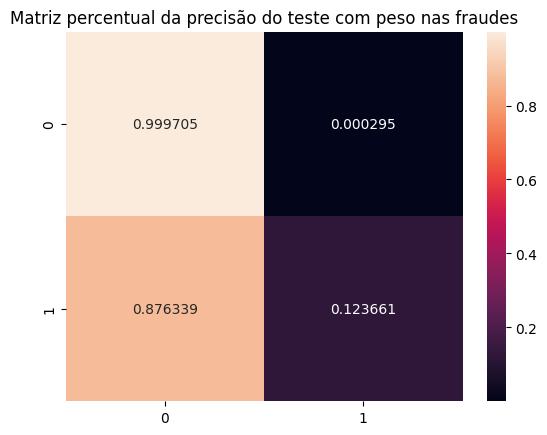

In [79]:
titulo = "Matriz percentual da precisão do teste com peso nas fraudes"
matriz_percentual_precision(*resultados, titulo)

Visualização do classification_report

In [80]:
print(classification_report(y_test, y_pred_test_weight))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.12      0.93      0.22      2145

    accuracy                           0.97    555719
   macro avg       0.56      0.95      0.60    555719
weighted avg       1.00      0.97      0.98    555719



O class weight está muito alto no momento, por conta do recall ter aumentado. Iremos otimizar isso.

### Utilização do grid search para otimizar os hiper parâmetros

O grid search foi utilizado para otimizar o modelo. Foram calculados 4800 fits, com cerca de 3 segundos por fit utilizando 3 cores do processador, totalizando cerca de 4 horas de treinamento dos modelos

In [81]:
'''

from sklearn.model_selection import StratifiedKFold

strk = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)

modelo_arvore_otimizado = DecisionTreeClassifier()

hiperparametros = {
    "criterion":["gini"], 
    "max_depth": [10],
    "class_weight": [None],
    "splitter": ["best"],
    "max_leaf_nodes": [None],
    "min_samples_leaf": [40]
    }

grid_search = GridSearchCV(
    estimator=modelo_arvore_otimizado,
    param_grid=hiperparametros,
    cv=strk,
    scoring="accuracy",
    n_jobs=3,
    verbose=2
    )


grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
'''


'\n\nfrom sklearn.model_selection import StratifiedKFold\n\nstrk = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)\n\nmodelo_arvore_otimizado = DecisionTreeClassifier()\n\nhiperparametros = {\n    "criterion":["gini"], \n    "max_depth": [10],\n    "class_weight": [None],\n    "splitter": ["best"],\n    "max_leaf_nodes": [None],\n    "min_samples_leaf": [40]\n    }\n\ngrid_search = GridSearchCV(\n    estimator=modelo_arvore_otimizado,\n    param_grid=hiperparametros,\n    cv=strk,\n    scoring="accuracy",\n    n_jobs=3,\n    verbose=2\n    )\n\n\ngrid_search.fit(X_train, y_train)\n\nbest_model = grid_search.best_estimator_\n'

Salvando o grid search em disco

In [82]:
# joblib.dump(grid_search, "./searchs/grid_search_1")

Salvando o modelo em disco

In [83]:
# joblib.dump(best_model, "./modelos/modelo_4")

### Treino dos modelos utilizando os parâmetros encontrados no grid_search

Com os parâmetros otimizados, nessa parte foi realizado o ajuste fino do modelo otimizando os melhores parâmetros pensando no dataset de teste

In [84]:
grid_search_1 = joblib.load("./searchs/grid_search_1")
best_model = grid_search_1.best_estimator_


In [85]:

'''
y_pred_test_otimizado = best_model.predict(X_test)

resultados = [y_test, y_pred_test_otimizado]
titulo = "Matriz percentual de recall dos resultados no dataframe de teste"
matriz_percentual_recall(*resultados, titulo)
'''


'\ny_pred_test_otimizado = best_model.predict(X_test)\n\nresultados = [y_test, y_pred_test_otimizado]\ntitulo = "Matriz percentual de recall dos resultados no dataframe de teste"\nmatriz_percentual_recall(*resultados, titulo)\n'

In [86]:
'''
y_pred_test_otimizado = best_model.predict(X_test)

resultados = [y_test, y_pred_test_otimizado]
titulo = "Matriz percentual de precisão dos resultados no dataframe de teste"
matriz_percentual_precision(*resultados, titulo)

'''


'\ny_pred_test_otimizado = best_model.predict(X_test)\n\nresultados = [y_test, y_pred_test_otimizado]\ntitulo = "Matriz percentual de precisão dos resultados no dataframe de teste"\nmatriz_percentual_precision(*resultados, titulo)\n\n'

In [87]:
gd_search = joblib.load("./searchs/grid_search_1")

In [88]:
gd_search.score

<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=12, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid={'class_weight': [None, 'balanced',
                                          {0: 1, 1: 250, 2: 1},
                                          {0: 1, 1: 400, 2: 1}],
                         'criterion': ['gini'], 'max_depth': [None, 10, 20, 30],
                         'max_leaf_nodes': [None, 10000, 20000, 50000, 100000],
                         'min_samples_leaf': [None, 10, 20, 30, 40, 50],
                         'splitter': ['best']},
             scoring='accuracy', verbose=2)>

Definição de uma função de treinamento e de uma função de previsão, que mostra o gráfico gerado pelas matrizes de confusão percentuais de recall e precision dos modelos. 

In [89]:

def train(model, X_train_t, y_train_t): 
    model.fit(X_train_t, y_train_t)

def predict(model, X_test_t = X_test, y_test_t = y_test):
    y_pred_test_t = model.predict(X_test_t)
    resultados = [y_test_t, y_pred_test_t]

    titulo = "Matriz percentual de precisão dos resultados no dataframe de teste"
    matriz_percentual_precision(*resultados, titulo)
    plt.show()
    titulo = "Matriz percentual do recall dos resultados no dataframe de teste"
    matriz_percentual_recall(*resultados, titulo)
    plt.show()

    print(classification_report(y_test, y_pred_test_t))




Ajuste fino dos modelos. Nessa etapa foram testados diversos hiperparâmetros

In [90]:

modelo_teste = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=10, 
    class_weight={0:160, 1:1}, 
    splitter="best", 
    max_leaf_nodes=None, 
    min_samples_leaf=40)

'''
    modelo_teste.fit(X_train, y_train)
    y_pred_test_t = modelo_teste.predict(X_test)
    resultados = [y_test, y_pred_test_t]
    matriz = confusion_matrix(*resultados)
    if recall(*resultados, 1) > 70 and precision(*resultados, 1) > 80: break
'''


'\n    modelo_teste.fit(X_train, y_train)\n    y_pred_test_t = modelo_teste.predict(X_test)\n    resultados = [y_test, y_pred_test_t]\n    matriz = confusion_matrix(*resultados)\n    if recall(*resultados, 1) > 70 and precision(*resultados, 1) > 80: break\n'

Técnica de oversample utilizada. A classe minoritária foi escalada em 60% da classe maioritária para encontrar os melhores resultados

In [91]:
from imblearn.over_sampling import RandomOverSampler
def oversample(strat=0.6, rs=42):
    oversampler = RandomOverSampler(sampling_strategy=strat, random_state=rs)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

Um exemplo do que ocorre na função

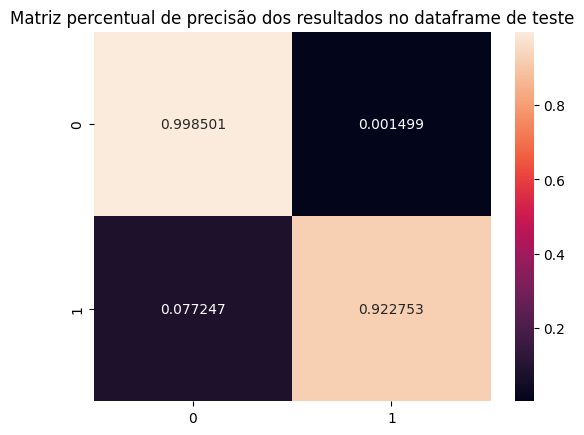

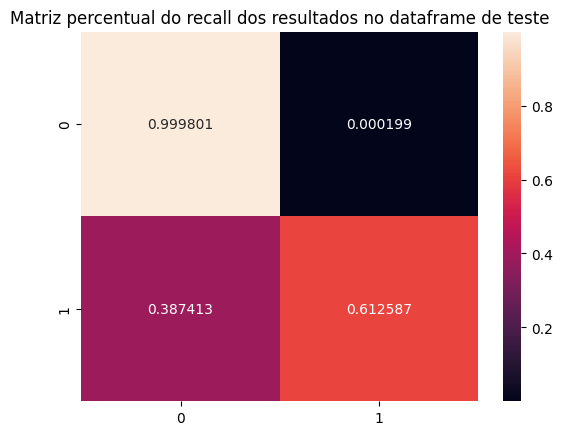

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.61      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.81      0.87    555719
weighted avg       1.00      1.00      1.00    555719



In [92]:
train(modelo_teste, *oversample())
y_pred_test_t = modelo_teste.predict(X_test)
resultados = [y_test, y_pred_test_t]

titulo = "Matriz percentual de precisão dos resultados no dataframe de teste"
matriz_percentual_precision(*resultados, titulo)
plt.show()
titulo = "Matriz percentual do recall dos resultados no dataframe de teste"
matriz_percentual_recall(*resultados, titulo)
plt.show()

print(classification_report(y_test, y_pred_test_t))

Salvando novamente o modelo

In [93]:
# joblib.dump(modelo_teste, "./modelos/modelo_5")

Até agora, o melhor modelo utilizou:

    criterion="gini", 
    max_depth=10, 
    class_weight={0:170, 1:1}, 
    splitter="best", 
    max_leaf_nodes=None, 
    min_samples_leaf=40

Além disso, utilizou como estratégia de treino um oversample na classe minoritária, com:

    sampling_strategy=0.6, 
    random_state=42

    

O modelo foi definido como:

In [94]:
modelo_teste_2 = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=10, 
    class_weight={0:170, 1:1}, 
    splitter="best", 
    max_leaf_nodes=None, 
    min_samples_leaf=40)




### Treinamento extensivo dos modelos para achar o melhor possível

O modelo apresentou variação conforme o treinamento dele. Por conta disso, realizou-se um treinamento extensivo do mesmo.

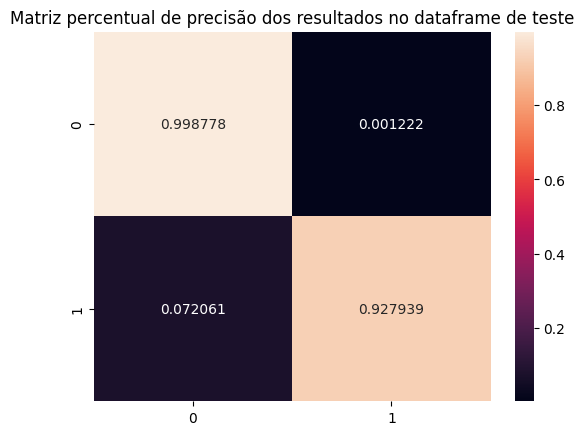

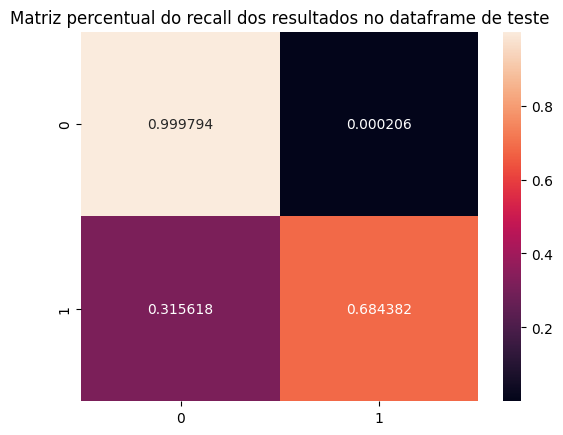

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.68      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



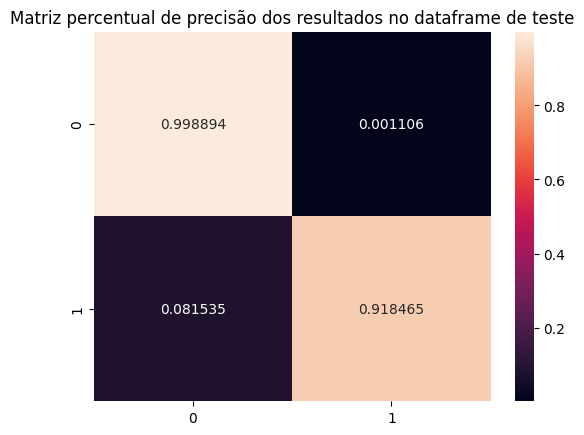

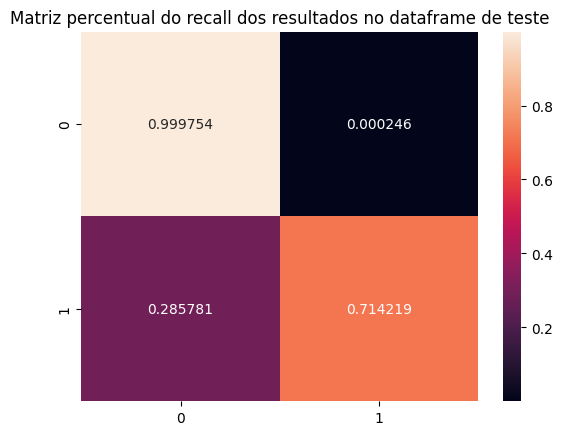

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.71      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719



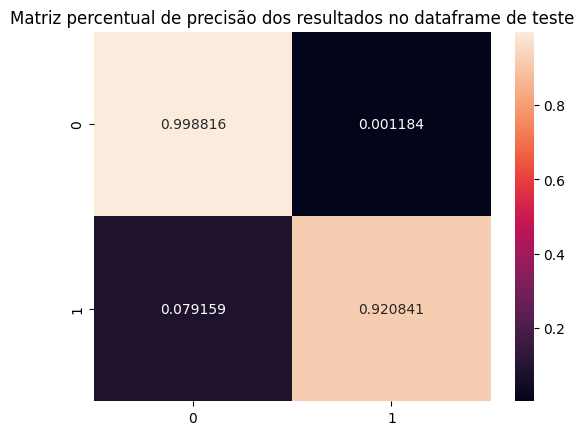

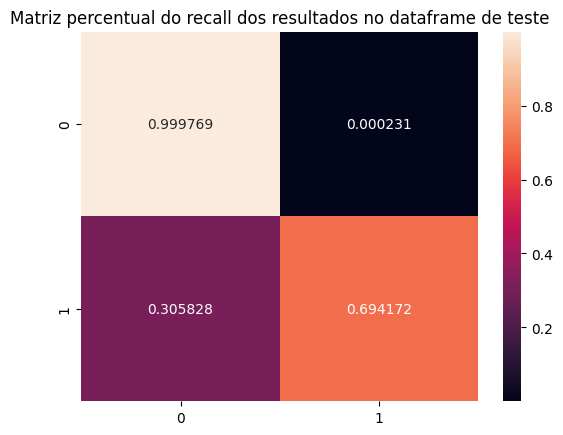

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.69      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.85      0.90    555719
weighted avg       1.00      1.00      1.00    555719



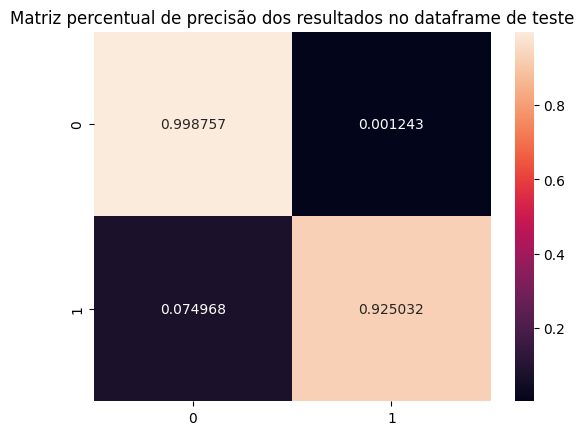

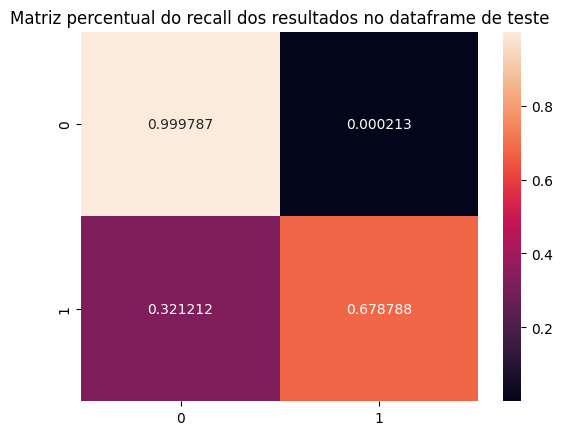

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.68      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



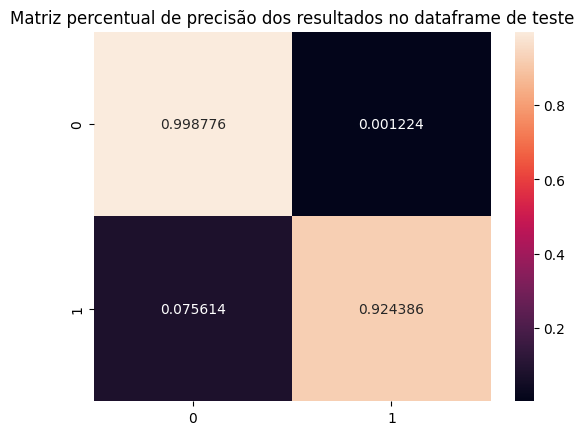

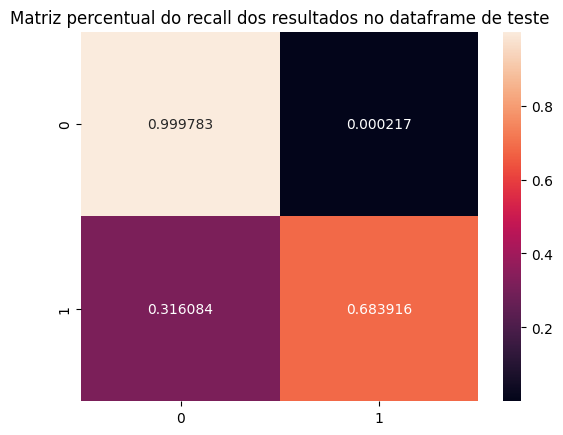

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.68      0.79      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



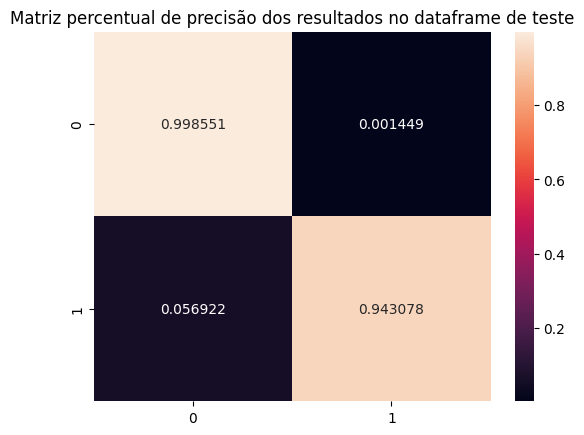

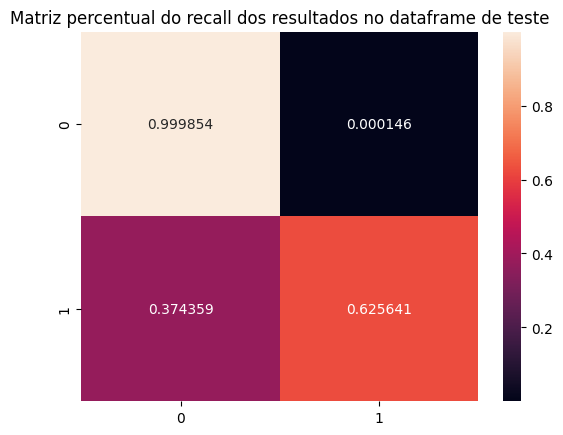

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.94      0.63      0.75      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.81      0.88    555719
weighted avg       1.00      1.00      1.00    555719



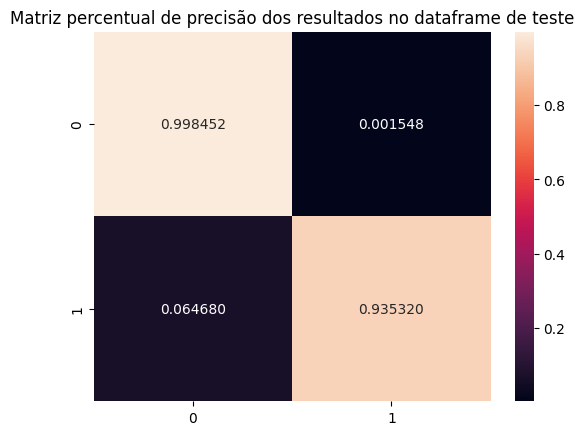

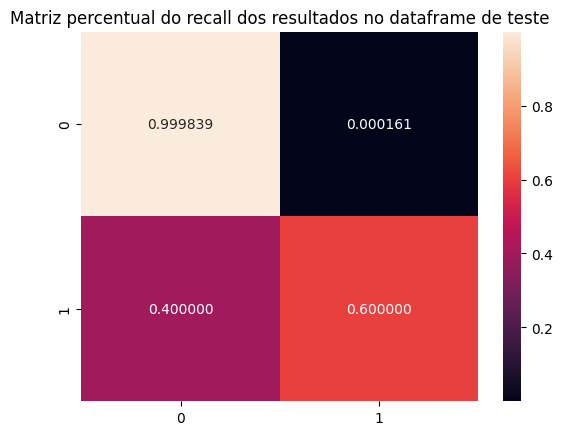

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.94      0.60      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.80      0.87    555719
weighted avg       1.00      1.00      1.00    555719



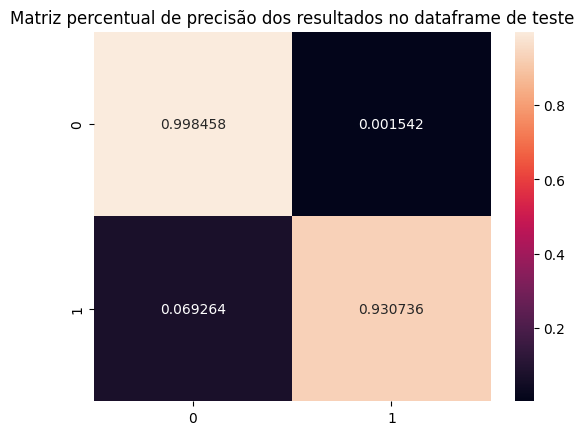

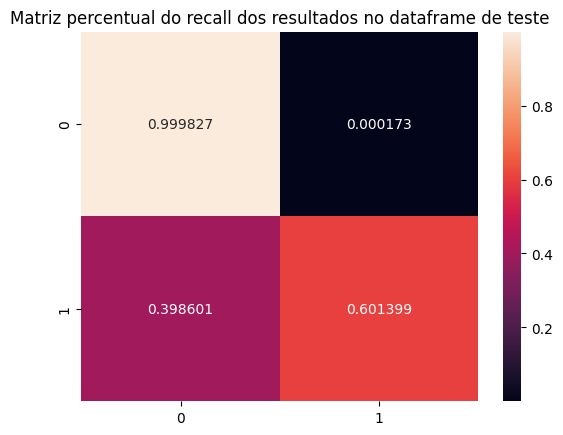

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.60      0.73      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.80      0.86    555719
weighted avg       1.00      1.00      1.00    555719



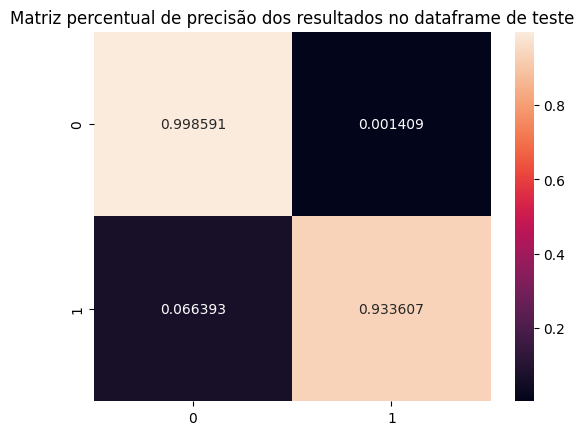

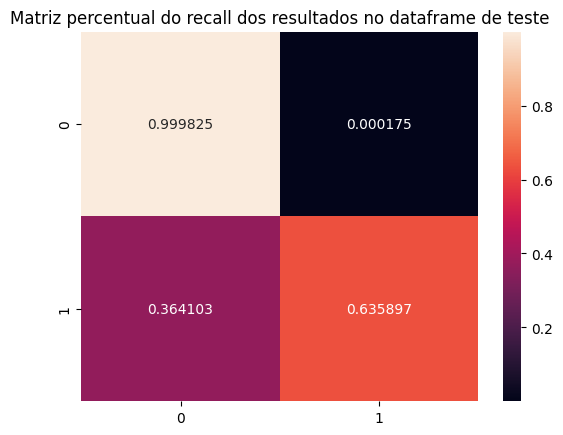

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.64      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.82      0.88    555719
weighted avg       1.00      1.00      1.00    555719



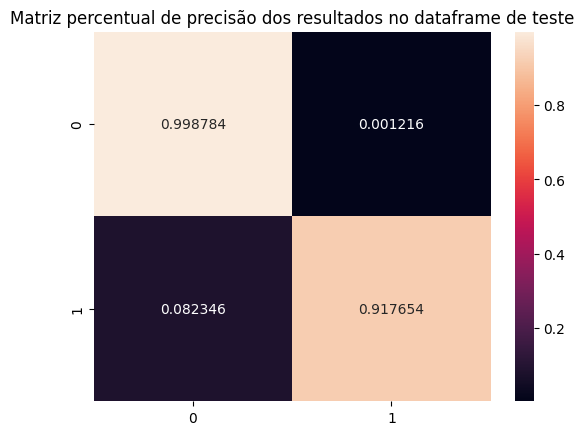

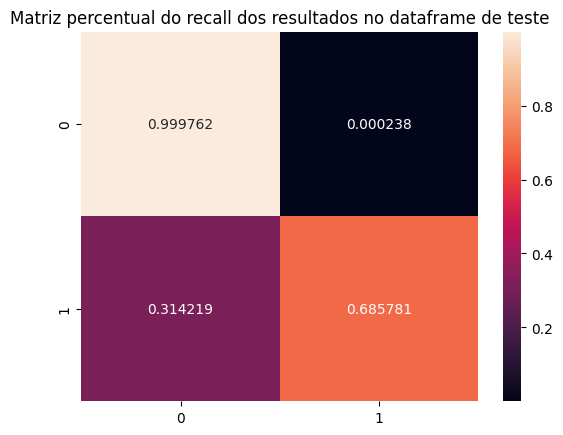

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.69      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.84      0.89    555719
weighted avg       1.00      1.00      1.00    555719



In [95]:
modelos = []

for i in range(10):
    modelo_teste_2 = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=10, 
    class_weight={0:170, 1:1}, 
    splitter="best", 
    max_leaf_nodes=None, 
    min_samples_leaf=40)
    train(modelo_teste_2, *oversample(strat=0.6, rs=42))
    predict(modelo_teste_2)
    modelos.append(modelo_teste_2)

### Registro em disco dos modelos

A lista de modelos foi guardada em disco

In [96]:
joblib.dump(modelos, "./modelos/lista_modelos")

['./modelos/lista_modelos']

### Visualização do melhor modelo encontrado

Após um longo processo de otimização, o melhor modelo encontrado teve 99.8% de precisão em compras não fraudadas e 91.9% de precisão em compras fraudadas. Além disso, possui 99.9% de recall em compras não fraudadas e 72.2% de recall em compras fraudadas, totalizando um f1-score de 1.00 em compras não fraudadas e 0.81 em compras fraudadas, com 0.90 de média

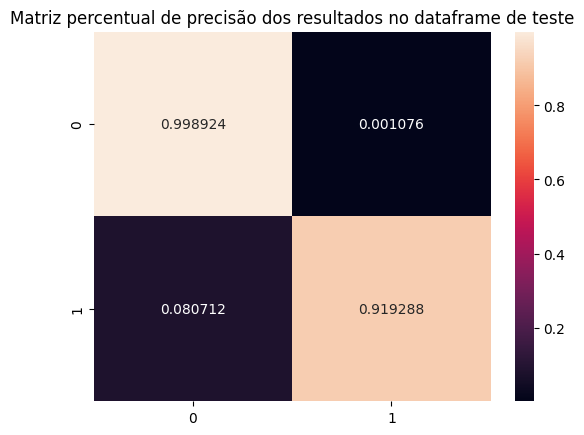

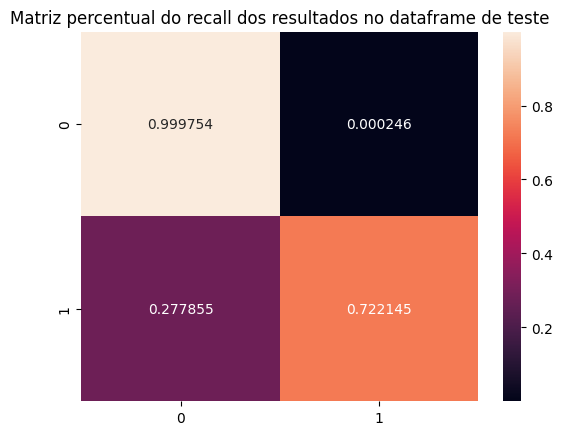

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.72      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719



In [97]:
modelo = joblib.load("./modelos/modelo_6")
predict(modelo)

### Visualização da árvore

A árvore mais otimizada que foi possível encontrar com os métodos utilizados é consideravelmente profunda, porém com mais de 20 features é de se esperar que ela tenha certa especificidade

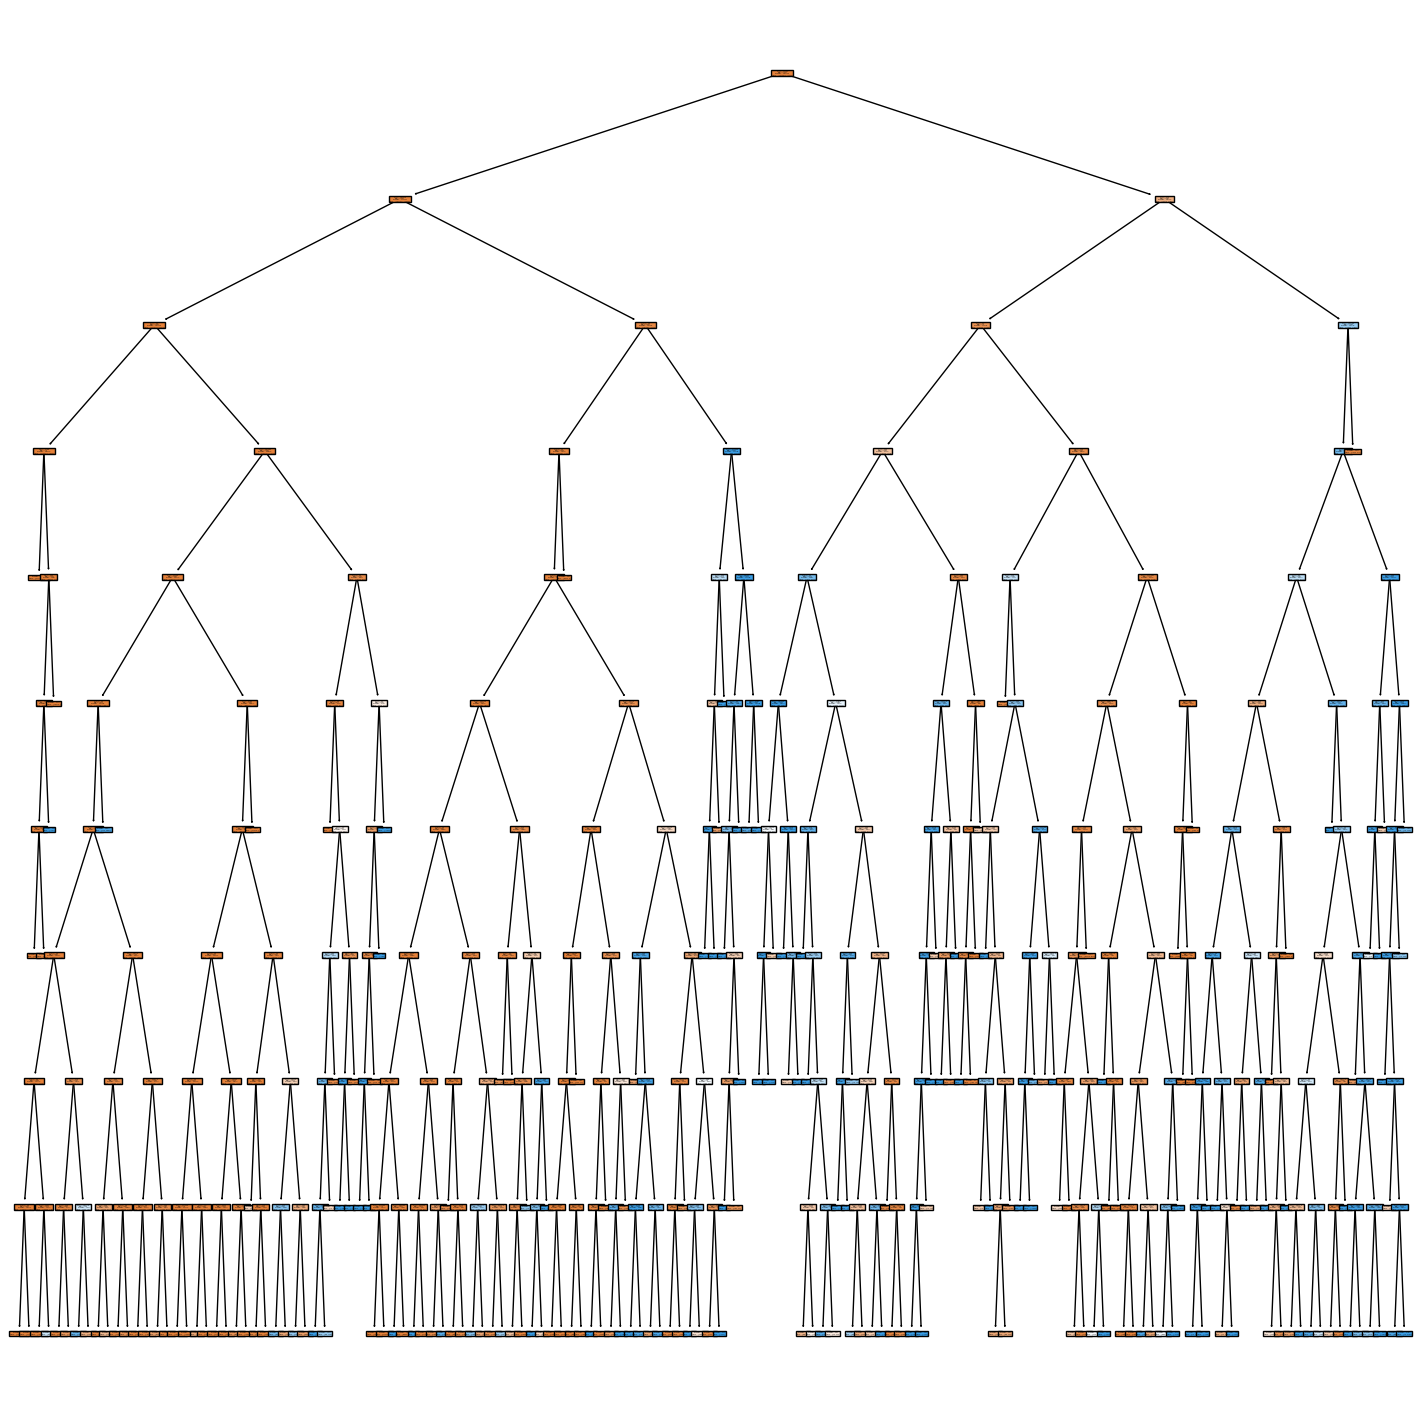

In [98]:
from sklearn.tree import plot_tree

fig, axs = plt.subplots(1, 1, figsize=(18,18))
plot_tree(modelo, filled=True)
plt.show()

### Observando métricas da árvore:

A árvore possui uma profundidade de 10 e um número de folhas de 214

In [99]:
modelo.get_depth()

10

In [100]:
modelo.get_n_leaves()

214

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score

def curva_roc():
    y_scores = modelo.predict_proba(X_test)[:, 1]
    y_true = y_test
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="purple", lw=2, label=f"Curva ROC (área = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taxa de falsos positivos")
    plt.ylabel("Taxa de verdadeiros positivos")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

In [115]:
def confusion(model, xtest=X_test, ytest=y_test):
    fig, ax = plt.subplots(figsize=(8,8));
    y_pred_test = model.predict(xtest)
    ConfusionMatrixDisplay.from_predictions(ytest, y_pred_test, ax=ax)
    plt.title("Matriz de confusão no dataframe de teste")
    plt.show()

### Conclusão

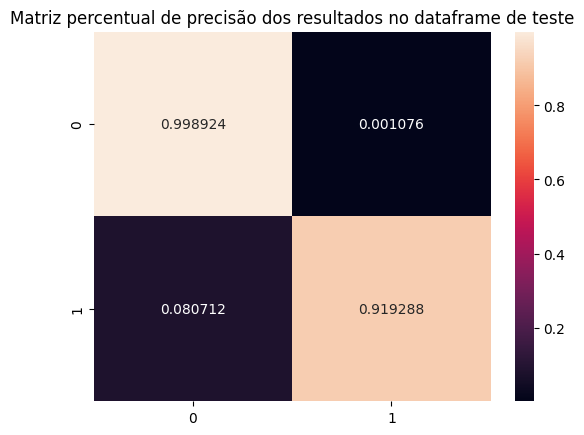

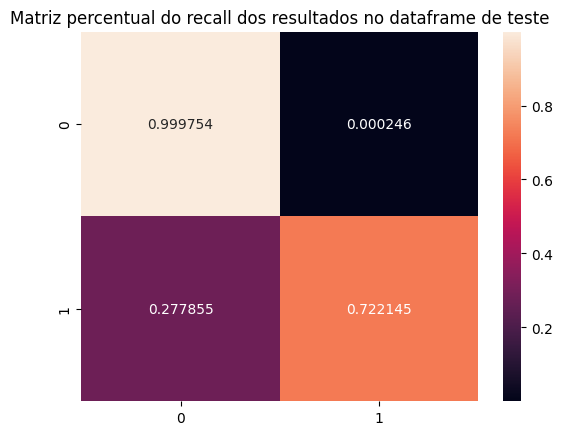

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.72      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719



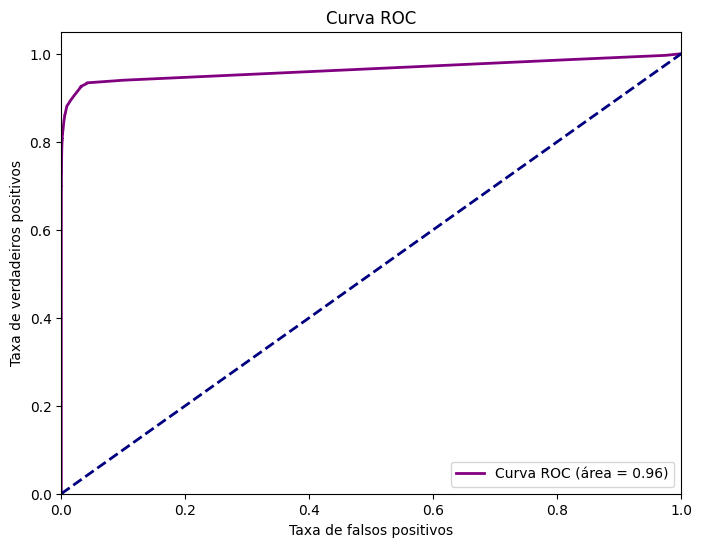

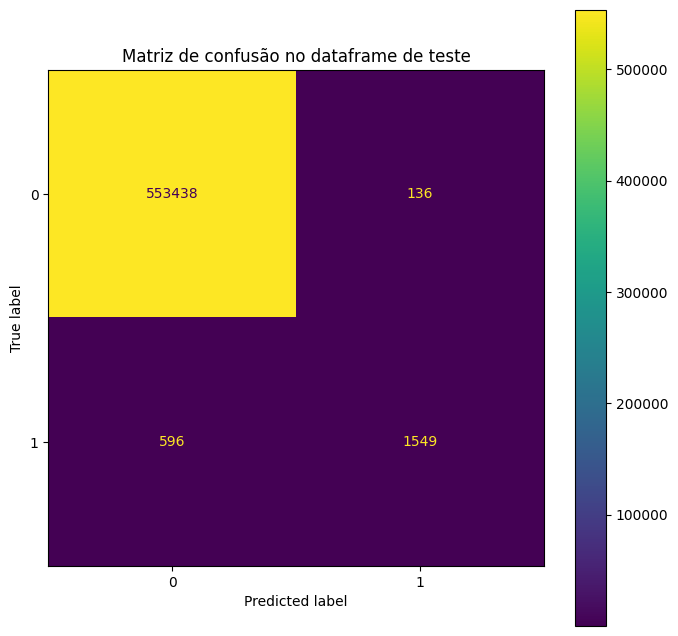

In [116]:
predict(modelo)
curva_roc()
confusion(modelo)

Depois do tratamento do dataframe, da análise exploratória dos dados, da criação de novas features relevantes, da criação do primeiro modelo, da tentativa inicial de otimização com o class_weight, da pesquisa com o grid_search, da otimização através da repetição excessiva, do ajuste fino e do oversample, foi possível criar um modelo com cerca de 92% de precisão e 72% de recall, totalizando um f1-score de cerca de 0.81 com uma curva ROC de 0.96 de área; tal qual foi considerado suficiente para o escopo do projeto que prevê com sucesso grande parte das fraudes na divisão de teste do dataframe. Foi possível visualizar a árvore de decisão formada e entender sua estrutura, e aplicar os conceitos na prática e entender melhor o que cada um dos parâmetros altera no score do modelo. Descobrimos quais são as métricas relevantes e formamos um modelo satisfatório de árvore de decisão.